In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import ParametricQuantumCircuit, QuantumCircuit, PauliOperator
from qulacs.gate import CZ, RY,RZ, merge, ParametricRY, ParametricRZ, PauliRotation
from qulacs import QuantumState, QuantumCircuit
from qulacs import DensityMatrix
from qulacs.gate import Probabilistic, Identity, X, Y, Z, T, DepolarizingNoise, RandomUnitary, P0, P1, add, merge, DephasingNoise, to_matrix_gate
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import SWAP
from qulacs.gate import H, S, Sdag, CNOT, SWAP, RZ
from qulacs import QuantumCircuit, QuantumState
from qulacs.observable import create_observable_from_openfermion_text

In [3]:
def noisy_time_evolution(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        PauliRotation([0, 1, 2, 3], [1, 3, 3, 1], theta).update_quantum_state(rho)
        PauliRotation([1, 2, 3, 4], [1, 3, 3, 1], theta).update_quantum_state(rho)
        PauliRotation([0, 2, 3, 4], [1, 1, 3, 3], theta).update_quantum_state(rho)
        PauliRotation([0, 1, 3, 4], [3, 1, 1, 3], theta).update_quantum_state(rho)
    
        for n in range(n_qubit):
            DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    return rho

def symmetric_channel_verification(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gate_error_ratio = 100, with_ancilla_noise = False):
    p_err_gadget = p_err / gate_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 4
    rho = rho_input.copy()

    stab_1 = merge(X(0), Z(1))
    stab_1 = merge(stab_1, Z(2))
    stab_1 = merge(stab_1, X(3))
    stab_2 = merge(X(1), Z(2))
    stab_2 = merge(stab_2, Z(3))
    stab_2 = merge(stab_2, X(4))
    stab_3 = merge(X(0), X(2))
    stab_3 = merge(stab_3, Z(3))
    stab_3 = merge(stab_3, Z(4))
    stab_4 = merge(Z(0), X(1))
    stab_4 = merge(stab_4, X(3))
    stab_4 = merge(stab_4, Z(4))

    stab_1.add_control_qubit(n_qubit, 1)
    stab_2.add_control_qubit(n_qubit+1, 1)
    stab_3.add_control_qubit(n_qubit+2, 1)
    stab_4.add_control_qubit(n_qubit+3, 1)

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        for i in range(n_ancilla):
            H(n_qubit+i).update_quantum_state(rho)
        stab_1.update_quantum_state(rho)
        stab_2.update_quantum_state(rho)
        stab_3.update_quantum_state(rho)
        stab_4.update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)
        
        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n_qubit+n, 1-(1-p_err)**layer_per_purification).update_quantum_state(rho)

        # U_D
        stab_1.update_quantum_state(rho)
        stab_2.update_quantum_state(rho)
        stab_3.update_quantum_state(rho)
        stab_4.update_quantum_state(rho)

        for i in range(n_ancilla):
            H(n_qubit+i).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        
        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho


def symmetric_channel_verification_correction(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gate_error_ratio = 100, with_ancilla_noise = False):
    p_err_gadget = p_err / gate_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 4
    rho = rho_input.copy()

    stab_1 = merge(X(0), Z(1))
    stab_1 = merge(stab_1, Z(2))
    stab_1 = merge(stab_1, X(3))
    stab_2 = merge(X(1), Z(2))
    stab_2 = merge(stab_2, Z(3))
    stab_2 = merge(stab_2, X(4))
    stab_3 = merge(X(0), X(2))
    stab_3 = merge(stab_3, Z(3))
    stab_3 = merge(stab_3, Z(4))
    stab_4 = merge(Z(0), X(1))
    stab_4 = merge(stab_4, X(3))
    stab_4 = merge(stab_4, Z(4))

    stab_1.add_control_qubit(n_qubit, 1)
    stab_2.add_control_qubit(n_qubit+1, 1)
    stab_3.add_control_qubit(n_qubit+2, 1)
    stab_4.add_control_qubit(n_qubit+3, 1)

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
            
        for i in range(n_ancilla):
            H(n_qubit+i).update_quantum_state(rho)
        stab_1.update_quantum_state(rho)
        stab_2.update_quantum_state(rho)
        stab_3.update_quantum_state(rho)
        stab_4.update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n_qubit+n, 1-(1-p_err)**layer_per_purification).update_quantum_state(rho)

        # U_D
        stab_1.update_quantum_state(rho)
        stab_2.update_quantum_state(rho)
        stab_3.update_quantum_state(rho)
        stab_4.update_quantum_state(rho)

        for i in range(n_ancilla):
            H(n_qubit+i).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        
        # feedback
        correct = X(0)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Y(0)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Z(0)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = X(1)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = Y(1)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Z(1)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)
        
        correct = X(2)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = Y(2)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = Z(2)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = X(3)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        correct = Y(3)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Z(3)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 1)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = X(4)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 0)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Y(4)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 1)
        correct.add_control_qubit(n_qubit+3, 1)
        correct.update_quantum_state(rho)

        correct = Z(4)
        correct = to_matrix_gate(correct)
        correct.add_control_qubit(n_qubit  , 0)
        correct.add_control_qubit(n_qubit+1, 1)
        correct.add_control_qubit(n_qubit+2, 0)
        correct.add_control_qubit(n_qubit+3, 0)
        correct.update_quantum_state(rho)

        rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho

In [4]:
n_qubit = 5
layer = 1000
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / layer
seed = 1234

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_list = np.zeros(len(p_err_list))
tracedist_channel_correct_layerwise_list = np.zeros(len(p_err_list))
overhead_channel_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    rho_initial.set_Haar_random_state(seed)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel_layerwise = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer)
    rho_channel_correct_layerwise = symmetric_channel_verification_correction(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_channel_layerwise = rho_channel_layerwise.get_matrix()
    rho_channel_correct_layerwise = rho_channel_correct_layerwise.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_channel_layerwise_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise / np.trace(rho_channel_layerwise), ord = 'nuc') / 2
    tracedist_channel_correct_layerwise_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_correct_layerwise / np.trace(rho_channel_correct_layerwise), ord = 'nuc') / 2
    overhead_channel_list[p_index] = 1/np.trace(rho_channel_layerwise)

    print(p_index)

/var/folders/x3/k6t57zl96dbf2zkg1y_49pdm0000gn/T/ipykernel_6986/3693159540.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  overhead_channel_list[p_index] = 1/np.trace(rho_channel_layerwise)


0
1
2
3
4
5
6


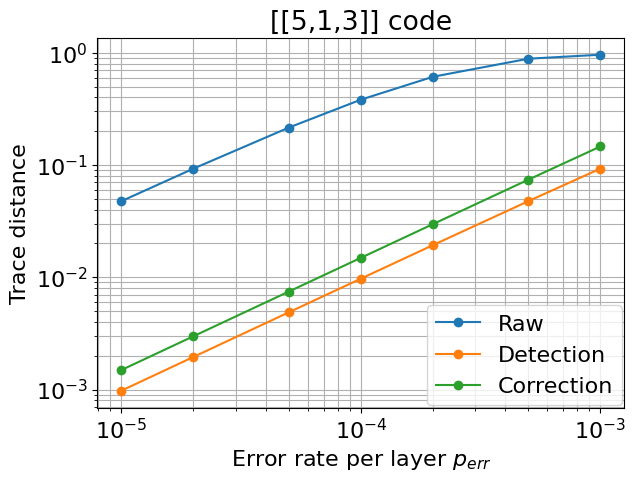

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_channel_layerwise_list, marker = 'o', label = 'Detection')
plt.plot(p_err_list, tracedist_channel_correct_layerwise_list, marker = 'o', label = 'Correction')

plt.xscale('log')
plt.yscale('log')
plt.title('[[5,1,3]] code')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('513_code.pdf', bbox_inches='tight')

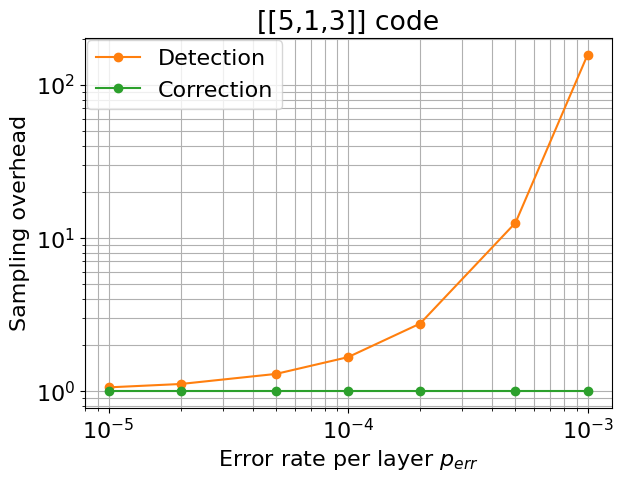

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

#plt.plot(p_err_list, overhead_channel_list, marker = 'o', label = 'Noisy')
plt.plot(p_err_list, overhead_channel_list, marker = 'o', label = 'Detection', color='#ff7f0e')
plt.plot(p_err_list, [1 for i in range(len(p_err_list))], marker = 'o', label = 'Correction', color='#2ca02c')

plt.xscale('log')
plt.yscale('log')
plt.title('[[5,1,3]] code')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Sampling overhead')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(0,1),loc='upper left',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('513_code_overhead.pdf', bbox_inches='tight')